# Guide to Kernels

In this notebook we'll expose the kernels available in GPJax and show how a custom polar kernel can be implemented.

In [1]:
import gpjax as gpx
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from optax import adam
from jax import jit 

key = jr.PRNGKey(123)

2022-02-08 17:31:51.296896: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## Supported Kernels 

The following kernels are supported in GPJax
* Matern - first, second and third order
* RBF or Squared Exponential
* Polynomial

The syntax for using these kernels is consistent across objects. However, the kernel's type influences the type of sample paths that can be drawn. To visualise this, we plot a set of 10 function draws per kernel in the following cell.

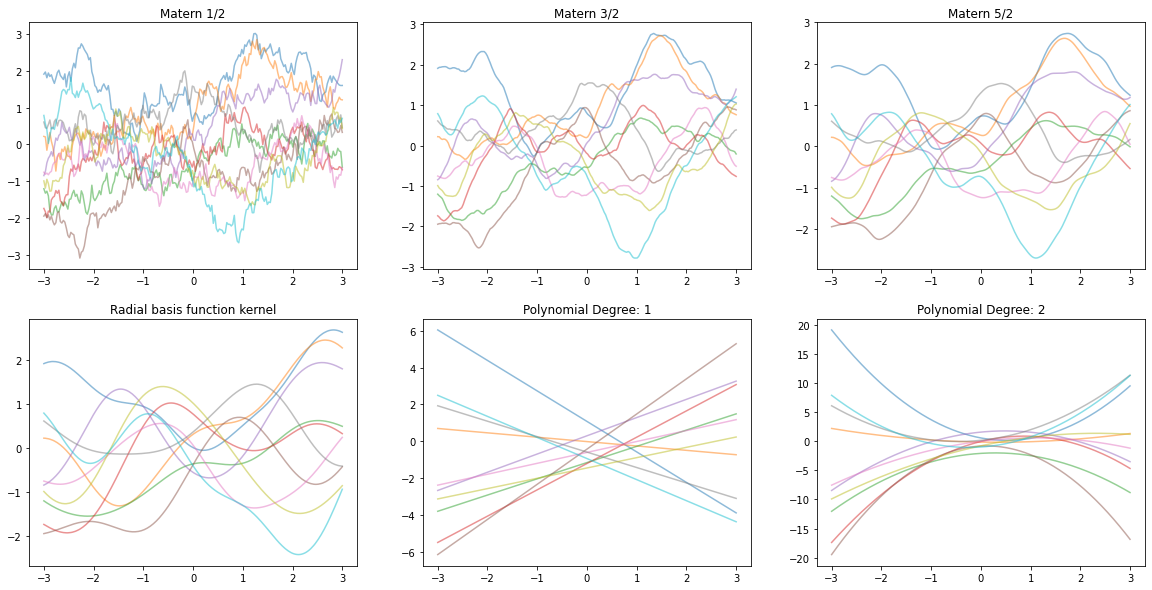

In [2]:
kernels = [gpx.Matern12(), gpx.Matern32(),gpx.Matern52(), gpx.RBF(), gpx.Polynomial(degree=1), gpx.Polynomial(degree=2)]
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

x = jnp.linspace(-3., 3., num=200).reshape(-1, 1)


for k, ax in zip(kernels, axes.ravel()):
    prior = gpx.Prior(kernel=k)
    params, _, _ = gpx.initialise(prior)
    rv = prior.random_variable(x, params)
    y = rv.sample(sample_shape = 10, seed = key)

    ax.plot(x, y.T, alpha=0.5)
    ax.set_title(k.name)

### Active dimensions

By default, kernels will operate over every dimension of the supplied inputs. For some use cases it is desirable to have the kernel operate over specific dimensions of the input data. Every kernel has an `active_dims` attribute that specificies the index values that the kernel should evaluate. 

To see this, consider the following 5-dimensional dataset for which we would like our RBF kernel to act on the first, second and fourth dimensions.

In [3]:
slice_kernel = gpx.RBF(active_dims = [0, 1, 3])

This will implicitly make the kernel have a single lengthscale per input dimensions. Our kernel is now an ARD kernel:

In [5]:
print(f"ARD: {slice_kernel.ard}")
print(f"Lengthscales: {slice_kernel.params['lengthscale']}")

ARD: True
Lengthscales: [1. 1. 1.]


We'll now simulate some data and evaluate the kernel on the previously selected input dimensions

In [6]:
x_matrix = jr.normal(key, shape = (50, 5))
K = gpx.kernels.gram(slice_kernel, x_matrix, slice_kernel.params)
print(K.shape)

(50, 50)


## Combination of Kernels

The product or sum of two positive define matrices yields a positive definite matrix. Consequently, summing or multiplying sets of kernels is a valid operation and can yield rich kernel functions. In GPJax, sums of kernels can be created by passing a list of kernels into the `SumKernel` object in the following way.

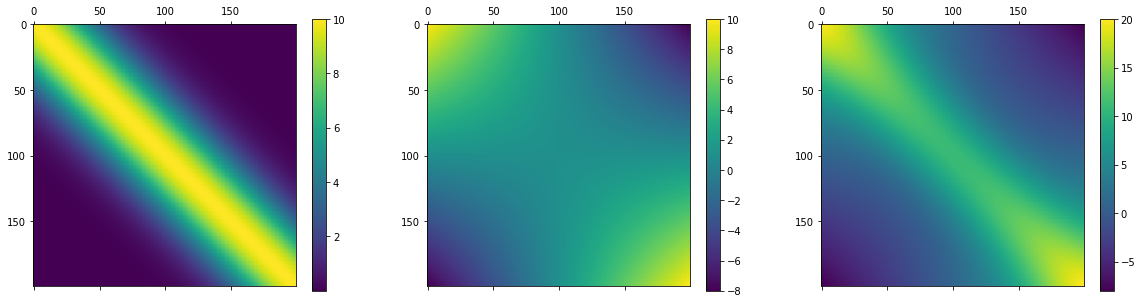

In [9]:
k1 = gpx.RBF()
k1._params = {'lengthscale': jnp.array(1.), 'variance': jnp.array(10.)}
k2 = gpx.Polynomial()
sum_k = gpx.SumKernel(kernel_set = [k1, k2])

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))
im0=ax[0].matshow(gpx.kernels.gram(k1, x, k1.params))
im1=ax[1].matshow(gpx.kernels.gram(k2, x, k2.params))
im2=ax[2].matshow(gpx.kernels.gram(sum_k, x, sum_k.params))


fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])

Similarily, products of kernels can be created through the `ProductKernel` object.

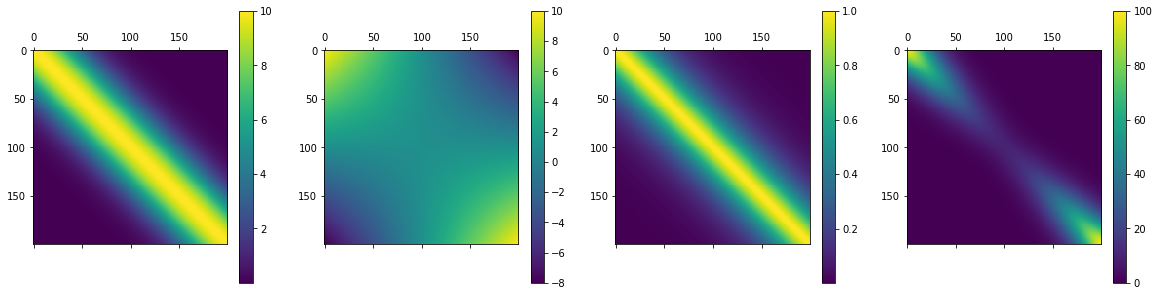

In [10]:
k3 = gpx.Matern32()
prod_k = gpx.ProductKernel(kernel_set = [k1, k2, k3])
fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
im0=ax[0].matshow(gpx.kernels.gram(k1, x, k1.params))
im1=ax[1].matshow(gpx.kernels.gram(k2, x, k2.params))
im2=ax[2].matshow(gpx.kernels.gram(k3, x, k3.params))
im3=ax[3].matshow(gpx.kernels.gram(prod_k, x, prod_k.params))


fig.colorbar(im0, ax=ax[0])
fig.colorbar(im1, ax=ax[1])
fig.colorbar(im2, ax=ax[2])
fig.colorbar(im3, ax=ax[3])

## Custom Kernel

If one wishes to implement their own kernel then the process is straightforward. There are two steps to achieving this 
1. List the kernel's parameters
2. Define the kernel's pairwise operation

We'll demonstrate this process now for a ciruclar kernel. This example is an adaption of the excellent guide given in the PYMC3 documentation and we would encourage the curious reader to visit their notebook which can be found [here](https://docs.pymc.io/pymc-examples/examples/gaussian_processes/GP-Circular.html).

### Circular Kernel

When the underlying space is polar, typical Euclidean kernels such as Matern kernels will be insufficient as the boundary. Circular kernels do not exhibit this behaviour and instead _wrap_ around the boundary points to create a smooth function. Such a kernel was given in [Padonou & Roustant (2015)](https://hal.inria.fr/hal-01119942v1) and for two angles $\theta, \theta'$ can be written as
$$W_c(\theta, \theta') = \left\lvert \left(1 + \tau \frac{d(\theta, \theta')}{c} \right) \left(1 - \frac{d(\theta, \theta')}{c} \right)^{\tau} \right\rvert \quad \tau \geq 4 \tag{1}.$$

Here we have the parameter $\tau$ which is analogous to a lengthscale for Euclidean stationary kernels as it controls the correlation between pairs of observations. Further, the distance metric $d$ here is an angular distance
$$d(\theta, \theta') = \lvert (\theta-\theta'+c) \operatorname{mod} 2c - c \rvert.$$

To implement this, one must write the following class 

In [ ]:
from chex import dataclass


def angular_distance(x, y, c):
    return jnp.abs((x - y + c) % (c * 2) - c)
    

@dataclass(repr=False)
class Polar(gpx.kernels.Kernel):
    period: float = 2*jnp.pi

    def __post_init__(self):
        self.c = self.period / 2.0  # in [0, \pi]


    def __call__(self, x: gpx.types.Array, y: gpx.types.Array, params: dict) -> gpx.types.Array:
        tau = params["tau"]
        t = angular_distance(x, y, self.c)
        K = (1 + tau * t / self.c) * jnp.clip(1 - t / self.c, 0, jnp.inf) ** tau
        return K.squeeze()

    @property
    def params(self) -> dict:
        return {'tau': jnp.array([4.])}

We can unpack this now to make better sense of it. In the kernel's `__init__` function we are simply specifying the length of a single period. Here, the underlying domain is a circle, so one period is simply $2\pi$. Next we define the kernel's `__call__` function which is a direct implementation of Equation 1. Finally, we define the Kernel's parameter property which contains just one value $\tau$. Now $\tau$ is defined to be greater than or equal to 4, so we initialise it at 4. 


### Custom Parameter Bijection

The constraint on $\tau$ will make optimisation challenging and it'd be much more helpful if we could transform $\tau$ to be on the full real line when we perform gradient descent on it. Fortunately, the `add_parameter` function in GPJax means we must simply define the parameter's name and corresponding bijection and everything else will be taken care of. Under the hood, a master configuration object is being updated when we call this function to register this parameter and its corresponding transform.

In [ ]:
from gpjax.config import add_parameter
import tensorflow_probability.substrates.jax.bijectors as tfb

add_parameter('tau',  tfb.Softplus(low=jnp.array(4.0)))

### Using our Polar Kernel

With a custom kernel now defined, we can go ahead and fit our new kernel. To do this, we randomly simulate a sequence of points on a circle and fit our GP to this using the above defined circular kernel. For further details on this process, it's advised to see the [Regression notebook](https://gpjax.readthedocs.io/en/latest/nbs/regression.html).

In [ ]:
# Simulate data
angles = jnp.linspace(0, 2 * jnp.pi, num=200).reshape(-1, 1)
n = 20
noise = 0.2

X = jnp.sort(jr.uniform(key, minval=0.0, maxval=jnp.pi * 2, shape=(n, 1)), axis=0)
y = 4 + jnp.cos(2 * X) + jr.normal(key, shape=X.shape) * noise
training = gpx.Dataset(X=X, y=y)

# Define Polar Gaussian process
PKern = Polar()
circlular_posterior = gpx.Prior(kernel=PKern) * gpx.Gaussian(num_datapoints=n)

# Initialise parameters and corresponding transformations
params, constrainer, unconstrainer = gpx.initialise(circlular_posterior)

# Optimise GP's marginal log-likelihood using Adam
mll = jit(circlular_posterior.marginal_log_likelihood(training, constrainer, negative=True))
learned_params = gpx.optax_fit(mll, params, adam(learning_rate=0.05), n_iters=1000)

# Untransform learned parameters
final_params = gpx.transform(learned_params, constrainer)

100%|██████████| 1000/1000 [00:16<00:00, 59.70it/s, Objective=29.8]             


### Prediction

We'll now query the GP's predictive posterior distribution at a linearly spaced set of test points and plot the results.

In [ ]:
mu = circlular_posterior.mean(training, final_params)(angles).squeeze()
one_sigma = jnp.sqrt(jnp.diag(circlular_posterior.variance(training, final_params)(angles)))

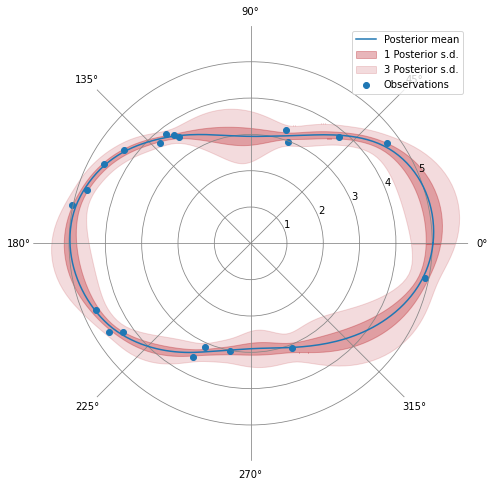

In [ ]:
fig = plt.figure(figsize=(10, 8))
gridspec = fig.add_gridspec(1, 1)
ax = plt.subplot(gridspec[0], polar=True)

ax.grid(color="#888888")  # Color the grid
ax.spines["polar"].set_visible(False)  # Show or hide the plot spine
ax.fill_between(
    angles.squeeze(),
    mu - one_sigma,
    mu + one_sigma,
    alpha=0.3,
    label=r"1 Posterior s.d.",
    color="#B5121B"
)
ax.fill_between(
    angles.squeeze(),
    mu - 3*one_sigma,
    mu + 3*one_sigma,
    alpha=0.15,
    label=r"3 Posterior s.d.",
    color="#B5121B"
)
ax.plot(angles, mu, label='Posterior mean')
ax.scatter(training.X, training.y, alpha=1, label="Observations")
ax.legend()

## System Configuration

In [ ]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Thomas Pinder'

Author: Thomas Pinder

Last updated: Tue Feb 08 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

jax                   : 0.2.21
gpjax                 : 0.4.0
sys                   : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
matplotlib            : 3.4.3
tensorflow_probability: 0.15.0

Watermark: 2.2.0

